In [20]:
#importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas.plotting import autocorrelation_plot

In [21]:
from sklearn.metrics import mean_squared_error

In [115]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

In [90]:
#lendo arquivo Train_SU63ISt.csv
dateparse = lambda dates: pd.datetime.strptime(dates, '%d-%m-%Y %H:%M')
dados_treino = pd.read_csv('Train_SU63ISt.csv',parse_dates=['Datetime'], index_col='Datetime',date_parser=dateparse)

In [91]:
#exibindo 5 primeiras linhas
print(dados_treino.head())

                     ID  Count
Datetime                      
2012-08-25 00:00:00   0      8
2012-08-25 01:00:00   1      2
2012-08-25 02:00:00   2      6
2012-08-25 03:00:00   3      2
2012-08-25 04:00:00   4      2


In [92]:
dados_treino = dados_treino.drop('ID',axis=1)

In [93]:
#tipo de dados
print(dados_treino.dtypes)

Count    int64
dtype: object


In [94]:
#exibindo informações do dado
print(dados_treino.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18288 entries, 2012-08-25 00:00:00 to 2014-09-25 23:00:00
Data columns (total 1 columns):
Count    18288 non-null int64
dtypes: int64(1)
memory usage: 285.8 KB
None


In [95]:
#exibindo estatística inicial do dado
print(dados_treino.describe())

              Count
count  18288.000000
mean     138.958115
std      153.467461
min        2.000000
25%       22.000000
50%       84.000000
75%      210.000000
max     1244.000000


In [96]:
#verificando se existem NaNs
print(dados_treino.isnull().values.any().sum())

0


In [97]:
print(dados_treino.head())

                     Count
Datetime                  
2012-08-25 00:00:00      8
2012-08-25 01:00:00      2
2012-08-25 02:00:00      6
2012-08-25 03:00:00      2
2012-08-25 04:00:00      2


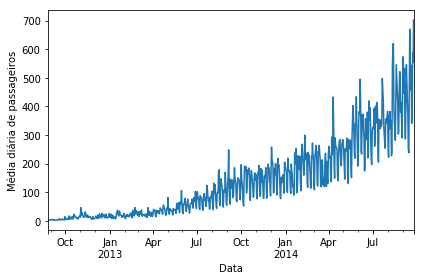

In [98]:
#Determinando a média diária
dados_media = dados_treino.resample('D').mean()
dados_media.Count.plot()
plt.xlabel('Data')
plt.ylabel('Média diária de passageiros')
plt.tight_layout()

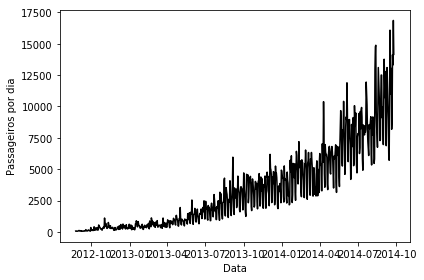

In [99]:
#Determinando a soma diária
dados_soma = dados_treino.resample('D').sum()
dados_soma = dados_soma[(dados_soma['Count'] != 0)]
plt.plot(dados_soma, color='black',label='Original')
plt.xlabel('Data')
plt.ylabel("Passageiros por dia")
plt.tight_layout()
plt.show()

Há uma tendencia geral crescente nos dados com provaveis variações sazonais

In [140]:
def test_stationarity(serie):
    #Determinando as estatisticas de rolamento
    rol_mean = serie.rolling(window=12).mean()
    rol_std = serie.rolling(window=12).std()
    plt.plot(serie, color='black',label='Original')
    plt.plot(rol_mean, color='red', label='Rolamento médio')
    plt.plot(rol_std, color='blue', label='Desvio Padrão Rolamento')
    plt.xlabel('Data')
    plt.ylabel("Passageiros por dia")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

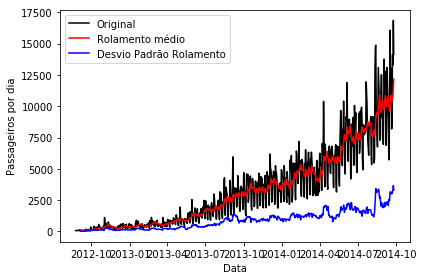

In [141]:
estacionariedade = test_stationarity(dados_soma)

Série temporal será constante quando:

 a) possuir média constante
    
 b) variância constante
    
 c) autocovariância não dependente do tempo
    
 Duas razões para não ser estácionária:
 
 a) tendencia - média varia no tempo
 
 b) sazonalidade - variações em prazos específicos

In [142]:
intervalo=1
indice = list(dados_soma.index)
diferenca = list()
for i in range(intervalo, len(dados_soma)):
        valor = dados_soma["Count"][i] - dados_soma["Count"][i - intervalo]
        diferenca.append(valor)

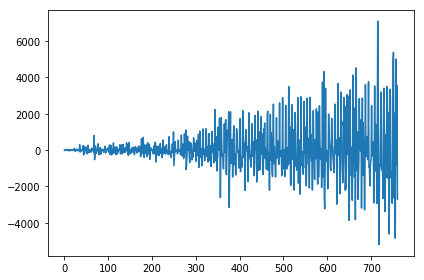

In [143]:
plt.plot(diferenca)
plt.tight_layout()
plt.show()

Penalizando valores altos mais do que valores baixos

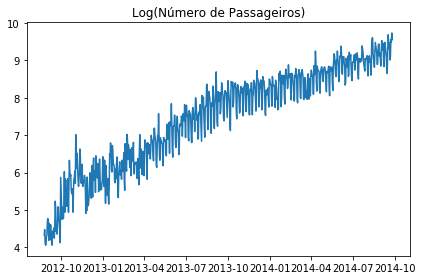

In [144]:
dados_log = np.log(dados_soma)
plt.title("Log(Número de Passageiros)")
plt.plot(dados_log)
plt.tight_layout()
plt.show()

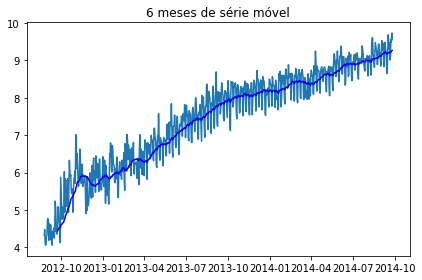

In [174]:
#Média móvel
media_movel = dados_log.rolling(30).mean()
plt.plot(dados_log)
plt.title("6 meses de série móvel")
plt.plot(media_movel, color='blue')
plt.tight_layout()
plt.show()

Subtraindo média movel dos dados originais

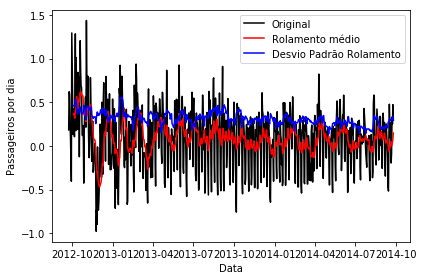

In [175]:
dados_log_media_movel_diff = dados_log - media_movel
dados_log_media_movel_diff.dropna(inplace=True)
test_stationarity(dados_log_media_movel_diff)

Média móvel ponderada: Valores mais recentes recebem um peso maior

In [177]:
dados_log_exp_avg = dados_log.ewm(halflife=30).mean()

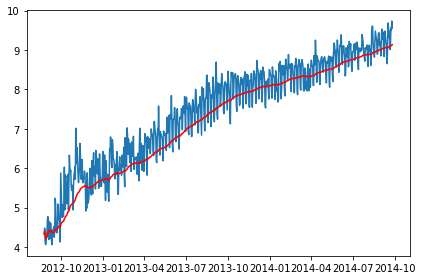

In [178]:
plt.plot(dados_log)
plt.plot(dados_log_exp_avg, color='red')
plt.tight_layout()
plt.show()

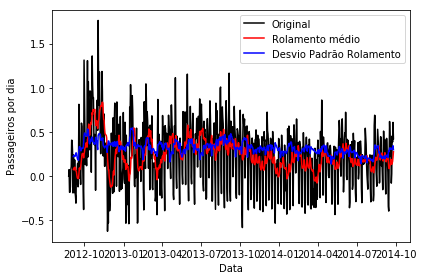

In [179]:
dados_log_ewma_diff = dados_log - dados_log_exp_avg
test_stationarity(dados_log_ewma_diff)

Eliminando tendencia e sazonalidade

Nem sempre a tecnica de redução da tendencia funciona, particularmente naqueles com alta sazonalidade. Existem dois modos de reduzirmos tendencia e sazonalidade:

Diferenciação: pegar a diferença num intervalo de tempo específico

Decomposição: modelar ambas tendencia e sazonalidade e remove-las do modelo

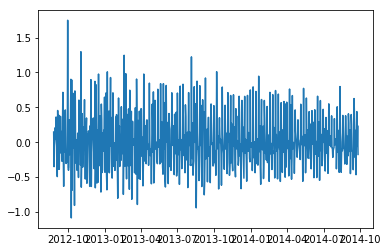

In [180]:
#Diferenciação
dados_log_diff = dados_log - dados_log.shift()
plt.plot(dados_log_diff)
plt.show()

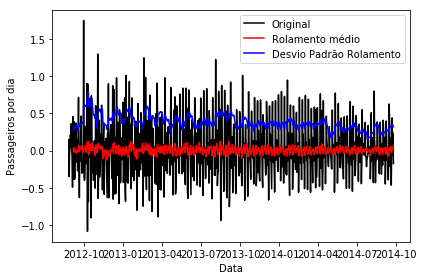

In [181]:
dados_log_diff.dropna(inplace=True)
test_stationarity(dados_log_diff)

In [182]:
#Decomposição
decomposicao = seasonal_decompose(dados_log)
tendencia = decomposicao.trend
sazonalidade = decomposicao.seasonal
residuo = decomposicao.resid

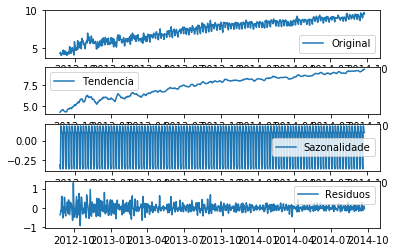

<Figure size 432x288 with 0 Axes>

In [183]:
plt.subplot(411)
plt.plot(dados_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(tendencia, label='Tendencia')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(sazonalidade,label='Sazonalidade')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuo, label='Residuos')
plt.legend(loc='best')
plt.show()
plt.tight_layout()

Notamos que tendencia e sazonalidade estão separados dos dados e desta forma podemos modelar os residuos

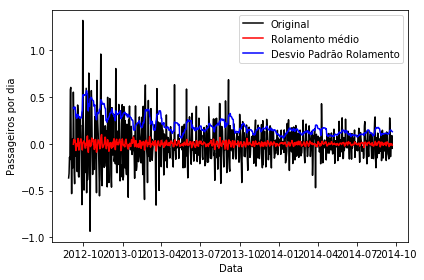

In [184]:
dados_log_decomposto = residuo
dados_log_decomposto.dropna(inplace=True)
test_stationarity(dados_log_decomposto)

A previsão ARIMA para séries temporais estacionárias é uma equação linear (regressão linear). A previsão depende dos parâmetros (p,q,d) do modelo ARIMA:

Número de termos auto-regressivos (AR) (p): termos AR são apenas os atrasos das variáveis dependentes. Por exemplo se p é 5, os previsores para x(t) serão x(t-1)...x(t-5).

Número de termos de média móvel (MA) (q): termos MA são os erros da previsão atrasados na equação da previsão. Por exemplo se q é 5, a previsão para x(t) será e(t-1)...e(t-5), onde e(i) é a diferença entre a média móvel no instante i e o valor atual.

Número de diferenças (d): eles são os números de diferenças não sazonais, i.e. neste caso pegamos a diferença de primeira ordem. Então podemos passar aquela variável e colocar d=o ou passar a variável original e colocar d=1. MAbos irão gerar o mesmo resultado.

Uma preocupação importante aqui é como determinar os valores de p e q. Utilizamos dois gráficos para determinar estes números.

Função de autocorrelação (ACF): é uma medida da correlação entre a série temporal com a versão atrasada dela mesma. Por exemplo um atraso de 5 ACF compararia as séries nos instante de tempo t1...t2 com as séries nos instantes t1-5...t2-5 (t1-5 e t2 sendo os pontos finais).

Função de autocorrelação parcial (PACF): mede a correlação entre a série temporal com a versão atrasada mas depois de eliminar as variações já explicadas pelas comparações intervenientes. 

In [185]:
atraso_acf = acf(dados_log_diff, nlags=20)
atraso_pacf = pacf(dados_log_diff, nlags=20, method='ols')

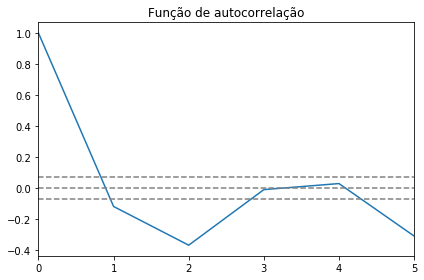

In [186]:
plt.plot(atraso_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dados_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dados_log_diff)),linestyle='--',color='gray')
plt.title('Função de autocorrelação')
plt.xlim([0,5])
plt.tight_layout()
plt.show()

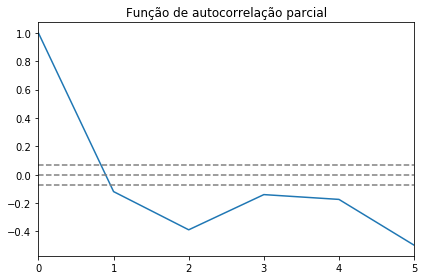

In [192]:
plt.plot(atraso_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dados_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dados_log_diff)),linestyle='--',color='gray')
plt.title('Função de autocorrelação parcial')
plt.xlim([0,5])
plt.tight_layout()
plt.show()

Modelo de AutoRegressão

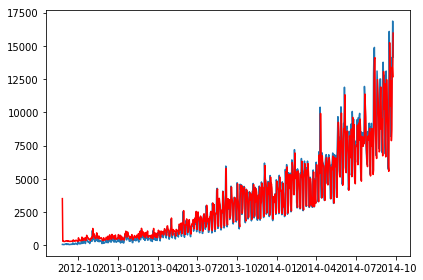

In [218]:
modelo = ARIMA(dados_soma, order=(1, 0, 0), freq=dados_soma.index.inferred_freq)  
resultado_AR = modelo.fit(disp=-1)  
plt.plot(dados_soma)
plt.plot(resultado_AR.fittedvalues, color='red')
plt.tight_layout()
plt.show()

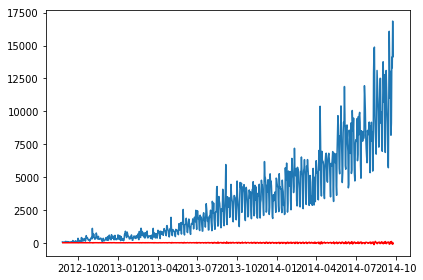

In [217]:
modelo = ARIMA(dados_soma, order=(1, 1, 0), freq=dados_soma.index.inferred_freq)  
resultado_AR = modelo.fit(disp=-1)  
plt.plot(dados_soma)
plt.plot(resultado_AR.fittedvalues, color='red')
plt.tight_layout()
plt.show()

Média móvel

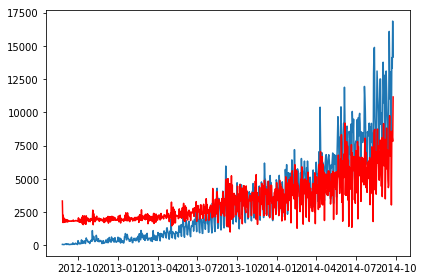

In [215]:
modelo = ARIMA(dados_soma, order=(0, 0, 1), freq=dados_soma.index.inferred_freq)  
resultado_AR = modelo.fit(disp=-1)  
plt.plot(dados_soma)
plt.plot(resultado_AR.fittedvalues, color='red')
plt.tight_layout()
plt.show()

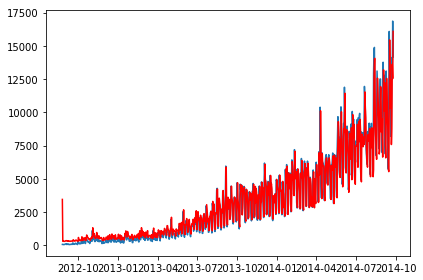

In [213]:
modelo = ARIMA(dados_soma, order=(1, 0, 1), freq=dados_soma.index.inferred_freq)  
resultado_AR = modelo.fit(disp=-1)  
plt.plot(dados_soma)
plt.plot(resultado_AR.fittedvalues, color='red')
plt.tight_layout()
plt.show()

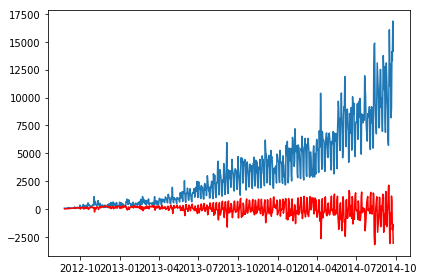

In [214]:
modelo = ARIMA(dados_soma, order=(1, 1, 1), freq=dados_soma.index.inferred_freq)  
resultado_AR = modelo.fit(disp=-1)  
plt.plot(dados_soma)
plt.plot(resultado_AR.fittedvalues, color='red')
plt.tight_layout()
plt.show()

Modelo (1,0,1) ajustou melhor os dados

Carregando arquivo com os dados para testar o modelo

In [262]:
#lendo arquivo Test_0qrQsBZ.csv
dateparse = lambda dates: pd.datetime.strptime(dates, '%d-%m-%Y %H:%M')
dados_teste = pd.read_csv('Test_0qrQsBZ.csv',parse_dates=['Datetime'], index_col='Datetime',date_parser=dateparse)

In [263]:
dados_teste.head()

,ID
Datetime,
2014-09-26 00:00:00,18288
2014-09-26 01:00:00,18289
2014-09-26 02:00:00,18290
2014-09-26 03:00:00,18291
2014-09-26 04:00:00,18292


In [264]:
dados_teste['Count'] =  [0 for x in dados_teste.index] 

In [265]:
dados_teste_soma = dados_teste.resample('D').sum()

In [268]:
dados_teste_soma = dados_teste_soma.drop('ID',axis=1)

In [303]:
previsao = list()
tempo = list(dados_soma.index)
historia = [x for x in dados_soma['Count']]

In [306]:
for t in range(len(dados_teste)):
    modelo = ARIMA(historia, order=(1,0,1))
    modelo_fit = modelo.fit(disp=0)
    resultado = modelo_fit.forecast()
    yhat = resultado[0]
    previsao.append(yhat)
    historia.append(yhat)
    tempo.append(dados_teste_soma.index[t])

IndexError: index 213 is out of bounds for axis 0 with size 213

In [300]:
print(range(len(dados_teste)))

range(0, 5112)


ValueError: x and y must have same first dimension, but have shapes (762,) and (10986,)

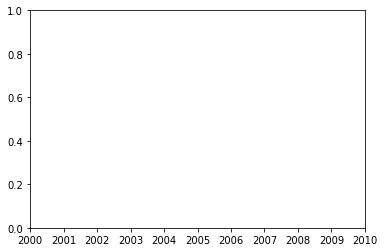

In [291]:
plt.plot(tempo,historia)
plt.tight_layout()
plt.show()